# Mode-Turbulence Coupling: Numerical Analysis
# M = 10^4, < Delta_tau > = 2pi, K = 1
# eta M^2 = 0.0125

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

# flattens nested arrays into one dimensional arrays
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

## Physical Parameters

In [2]:
# eta * Ma ^2 = 0.0125
Ma = 0.0125 ** (1/2)
K = 1
eta = 1

## Functions of Ma

In [3]:
meandeltaT = 2 * np.pi

# variables for generating F1
stdF1 = eta * Ma**2 / meandeltaT
limitY1 = eta / meandeltaT

# variables for generating F2 and G1
stdF2 = eta * Ma**2
limitY2 = eta 

## Calculation parameters

In [4]:
L = 1
M = 10**4
M_short = 200
N = 1
m = 10**2

J = 300
dTau = 2 * np.pi / J

Tr = K * meandeltaT

## Initial Conditions

In [5]:
initial_AT = 0
initial_dAdT = 0

### Time Functions

In [6]:
# deltaT is the length of each eddy turnover
def fundeltaT(n_bins, M, dTau):
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
        deltaT.append(deltaTtemp2)
    
    # plots deltaT distribution  
    deltaT = flatten(deltaT)
    count, bins, ignored = plt.hist(deltaT, 80, density=True)
    plt.title("Delta T")
    plt.xlabel("Delta T")
    plt.show()
    
    return deltaT

# Tturb adds up the delta T's
def funTturb(deltaT):
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    Tturb.pop(-1)
    return Tturb

### F_k Function

In [7]:
# generating F1, F2, G1
def funF_k(std, limit, deltaT, Tturb):
    F_k =[]
    time = []
    y1 = 0
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], deltaT[i] / dTau):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                time.append(j + Tturb[i])
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k, time

### Huen's Method Function

In [8]:
def funAmp(F1, F2, G1, dTau, A, dAdt):
    # huen's method
    
    Amp = [A]
    t = 0.0
    amptime = [t]
    u = dAdt
    
    for i in range(0, int(len(F1)) -2):
        m1 = u
        k1 = -( F1[i] * u ) - ( 1 + G1[i] ) * A + F2[i]
        m2 = u + dTau * k1
        A_2 = A + dTau * m1
        u_2 = m2
        k2 = -( F1[i + 1] * u_2 ) - ( 1 + G1[i + 1] ) * A_2 + F2[i + 1]
        m2 = u * dTau * k2
        t = t + dTau
        A = A + (dTau / 2) * (m1 + m2)
        u = u + (dTau / 2) * (k1 + k2)
        Amp.append(A)
        amptime.append(t)

    Amp = Amp[:-1]
    amptime = amptime[:-1]
    nextAmp = Amp[-1]
    
    return Amp, amptime, nextAmp, u

### Alpha Function

In [9]:
def funAlpha(A, t, alpha, delt):

    # the number of intervals is the total time (Tmax)/delT
    numsegments = int(t[len(t)-1]/delt)

    # 2d array containing an array for amplitudes in each interval
    ampsegments = []

    # this loop divides the total duration T(max) into equal intervals of delT
    # and adds corresponding amplitudes in each time segment to ampsegments 
    i = 0
    for count in range(0, numsegments):
        # amp segment contains the amplitudes in the specified time segment
        ampsegment = []
        # checks if that time is withint the correct time segment
        while i < len(t)-1:
            if (t[i] < (count+1)*meandeltaT):
                # adds the corresponding amplitude if the time is within specified time segment
                ampsegment.append(A[i])
                i+=1
            else:
                # breaks the while loop if the time is outside the time segment 
                # and moves to the next time segment
                break        
        ampsegments.append(ampsegment)


    # take Abar(T) = rms(A in delT)
    # Abar is the root mean square (RMS) of A in delT   
    Abar = []    
    for ampsegment in ampsegments:
        Abar.append(FunRMS(ampsegment))

    # in order to better exhibit the distribution of the full range of values of Abar, use instead
    # alpha = log(Abar) so -4 <= alpha <= 0
    tempalpha = FunLog(Abar)
    alpha.append(tempalpha)
    
    return alpha

### Plotting Functions

In [10]:
def Funplots(t, g1, f1, f2):

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, g1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('G\u2081', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()
    
def FunHist(F1, F2, G1):
    plt.hist(F1, 20)
    plt.title("F1")
    plt.show()
    
    plt.hist(G1, 20)
    plt.title("G1")
    plt.show()
    
    plt.hist(F2, 20)
    plt.title("F2")
    plt.show()
    
def FunplotAmp(amptime, Amp):
    plt.figure(figsize=(40,10))
    plt.plot(amptime, Amp, 'k')
    plt.title('Amplitude of the Mode', **title_font)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

In [11]:
# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

# Root mean square
def FunRMS(A):
    tot = 0
    for i in A:
        tot += i ** 2
    avg = tot / len(A)
    RMS = avg**(1/2)
    return RMS

## Evolution 1

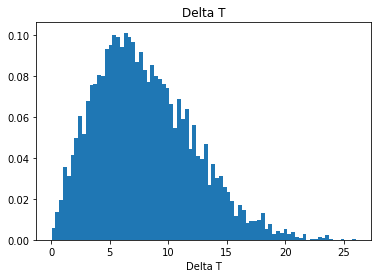

In [12]:
# deltaT is the length of each eddy turnover
deltaT = fundeltaT(n_bins, M, dTau)

# Tturb is the consecutive sum of deltaT's so each value marks a new eddy
Tturb = funTturb(deltaT)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


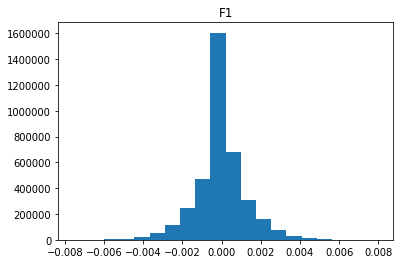

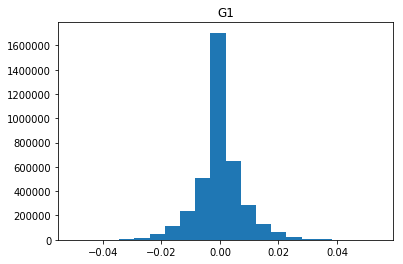

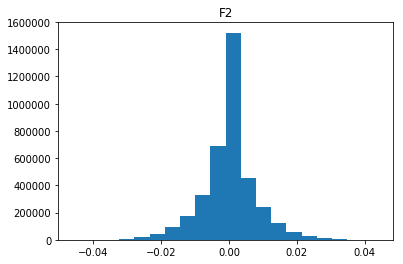

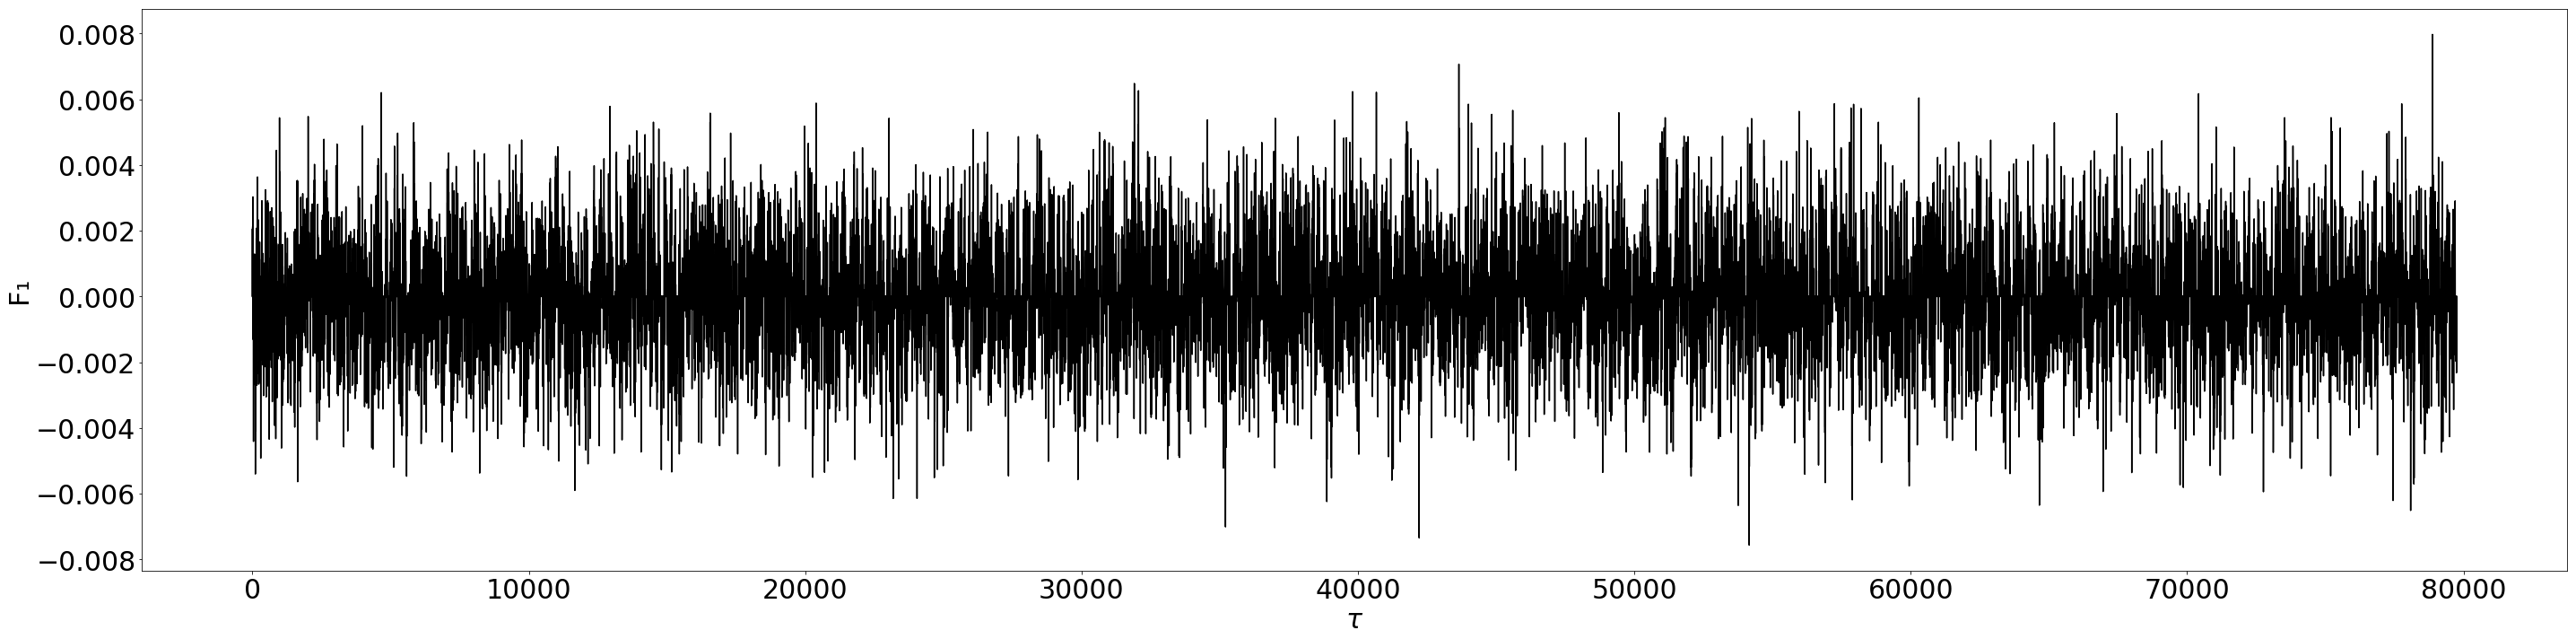

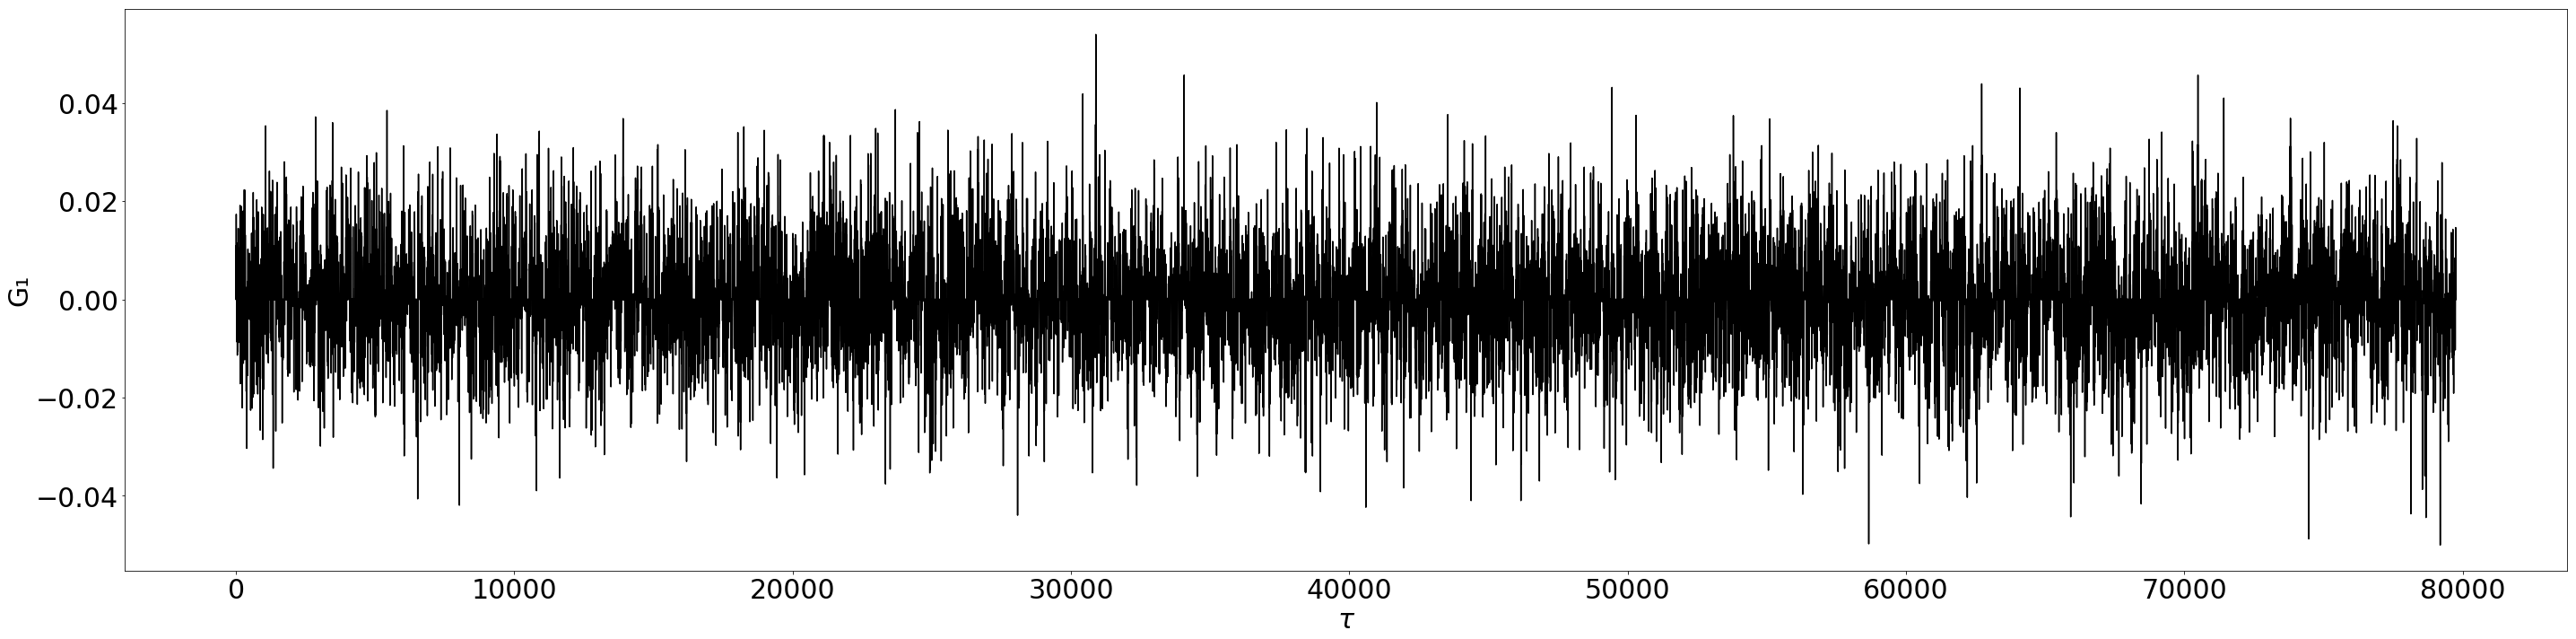

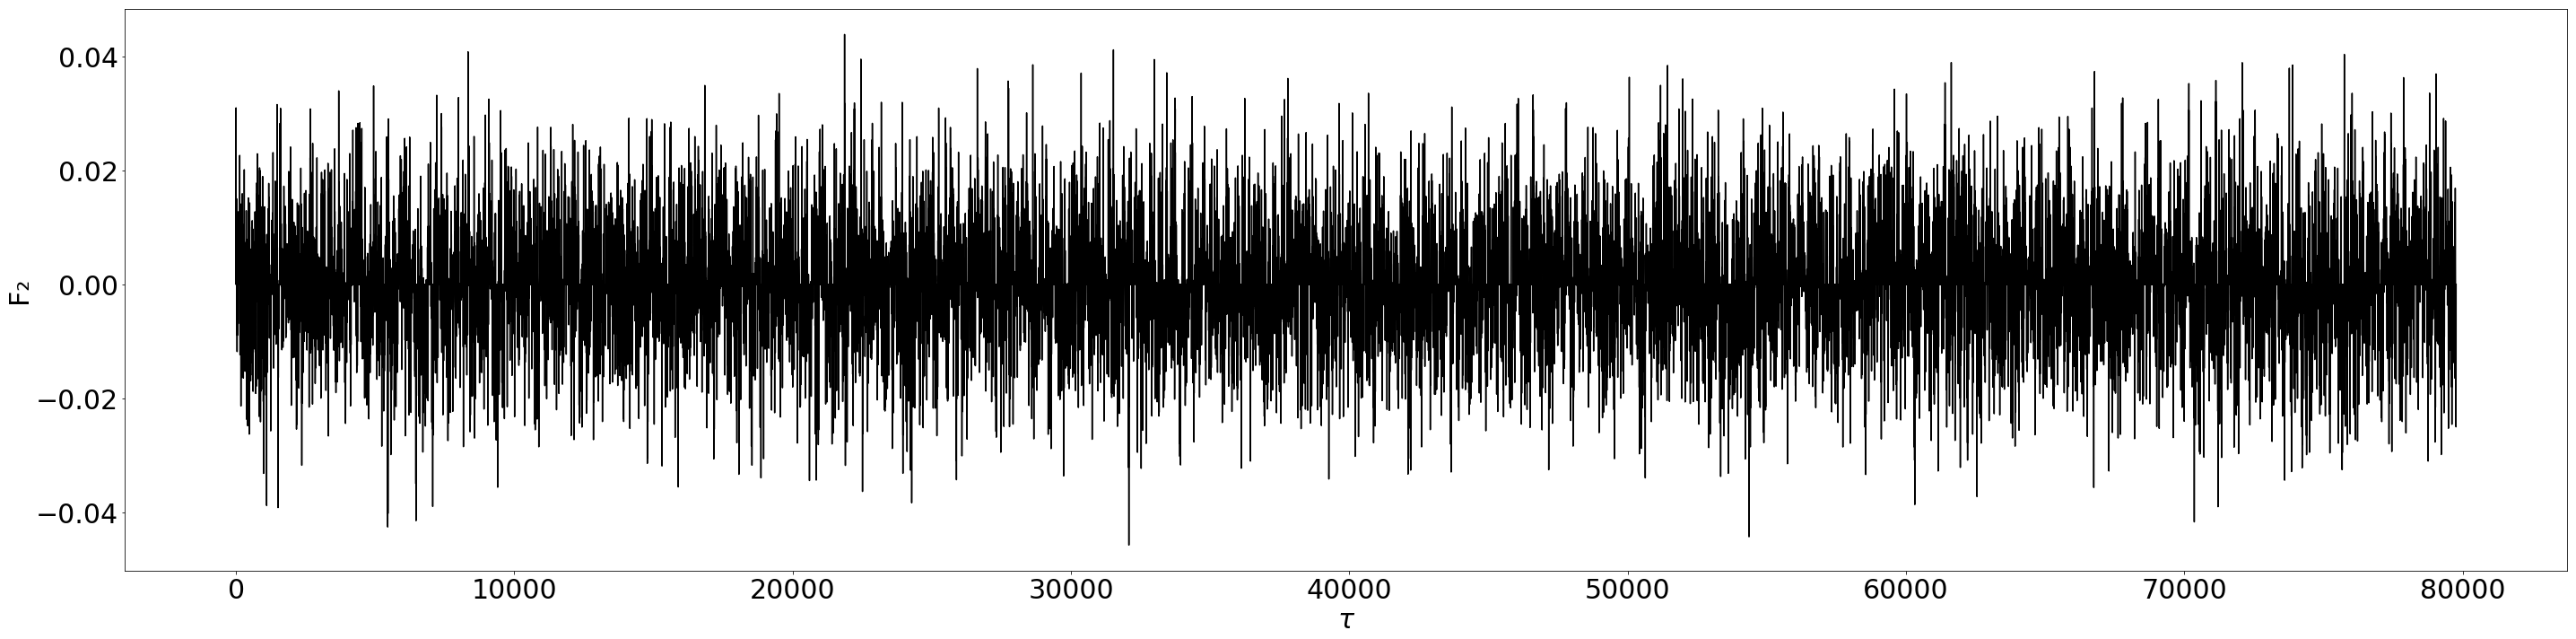

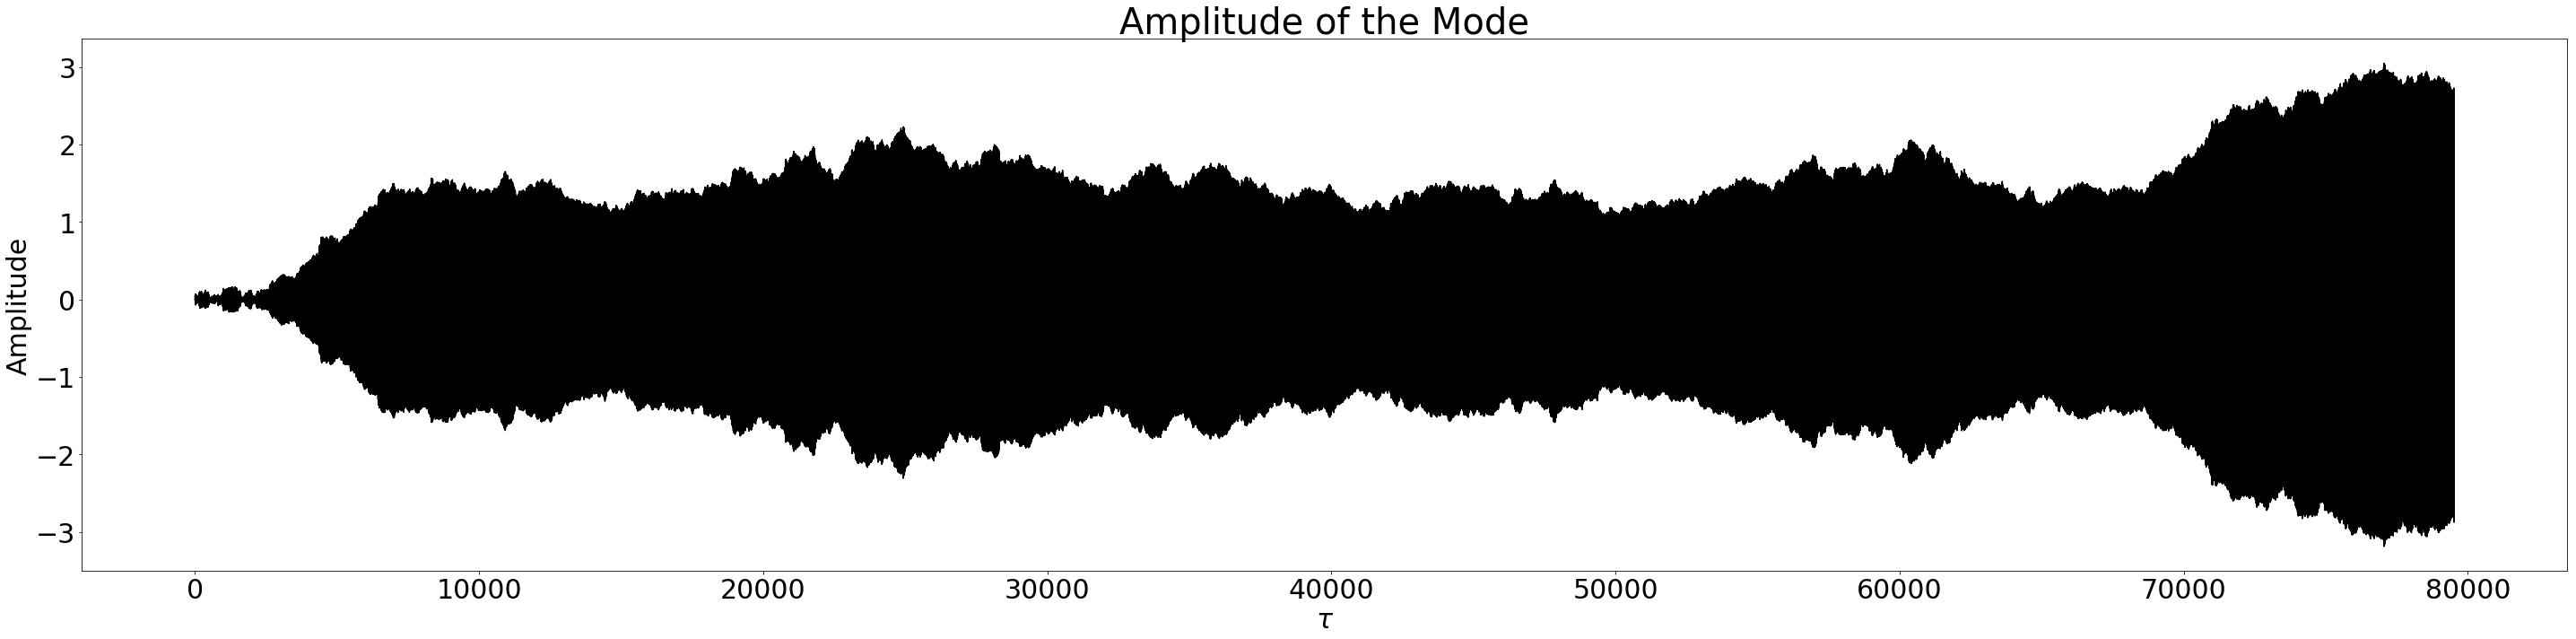

In [13]:
# store F_k for all evolutions
total_F1 = []
total_F2 = []
total_G1 = []

# generate F1, F2, G1
F1, time = funF_k(stdF1, limitY1, deltaT, Tturb)
F2, time = funF_k(stdF2, limitY2, deltaT, Tturb)
G1, time = funF_k(stdF2, limitY2, deltaT, Tturb)

total_F1.append(F1)
total_F2.append(F2)
total_G1.append(G1)

FunHist(F1, F2, G1)
    
Funplots(time, G1, F1, F2)

# store amplitudes for all evolutions
total_Amp = []

Amp, amptime, nextAmp, nextdAdt = funAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT)

total_Amp.append(Amp)

FunplotAmp(amptime, Amp)

## Beginning of the run

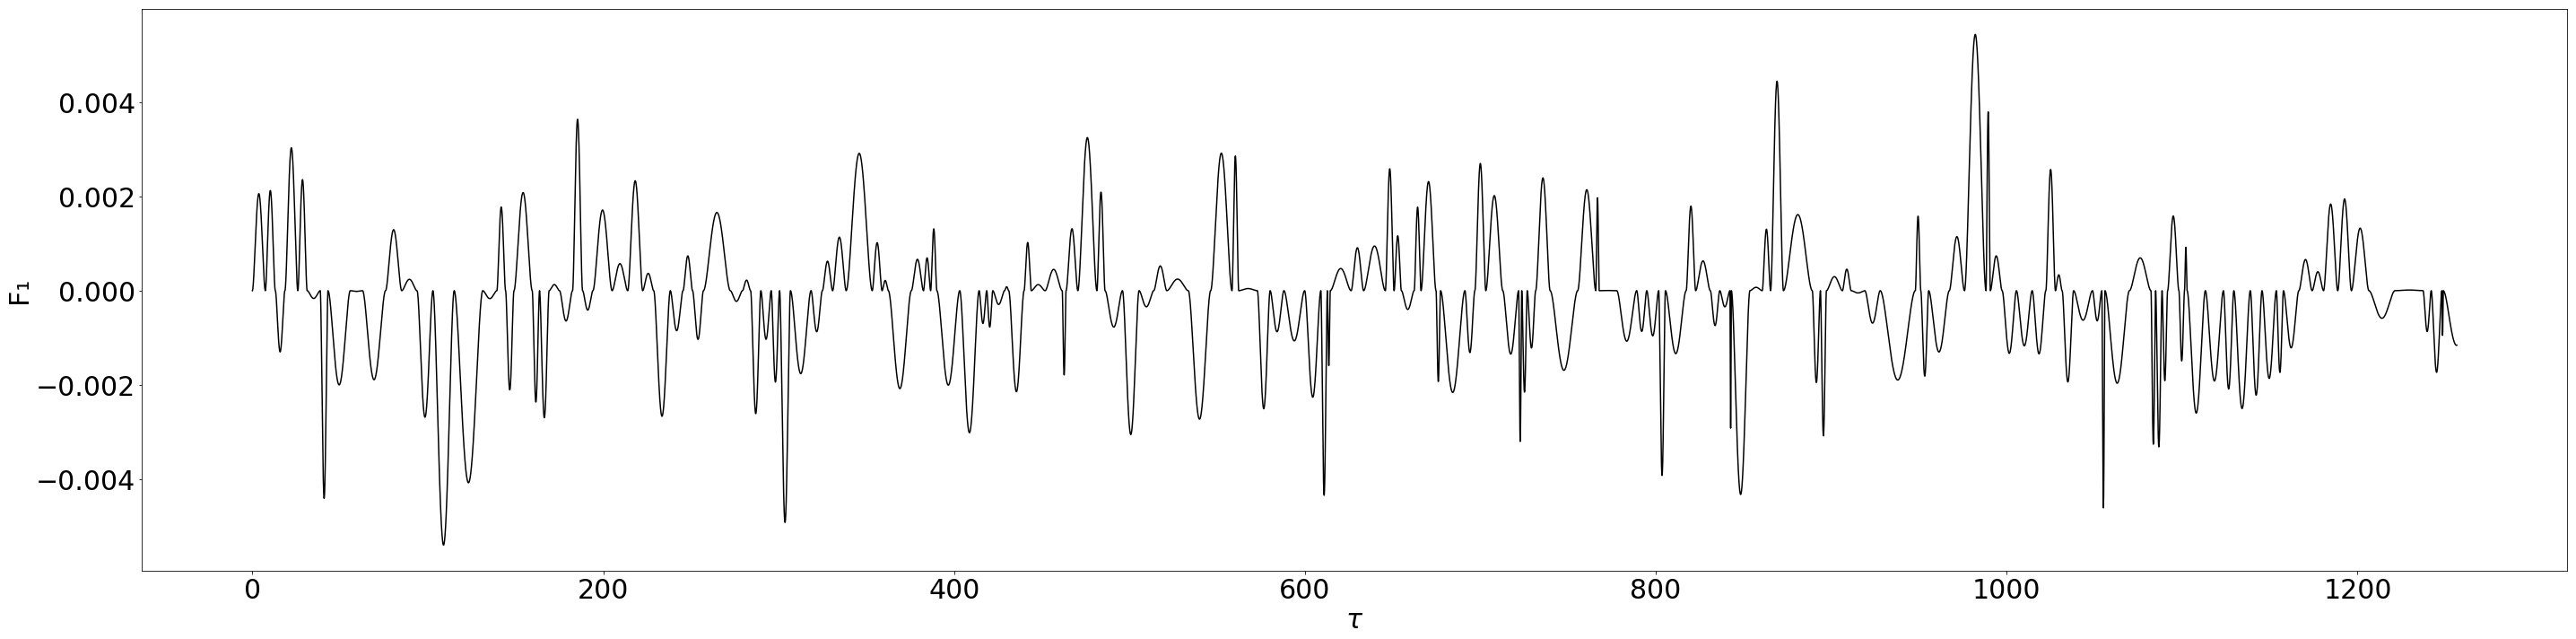

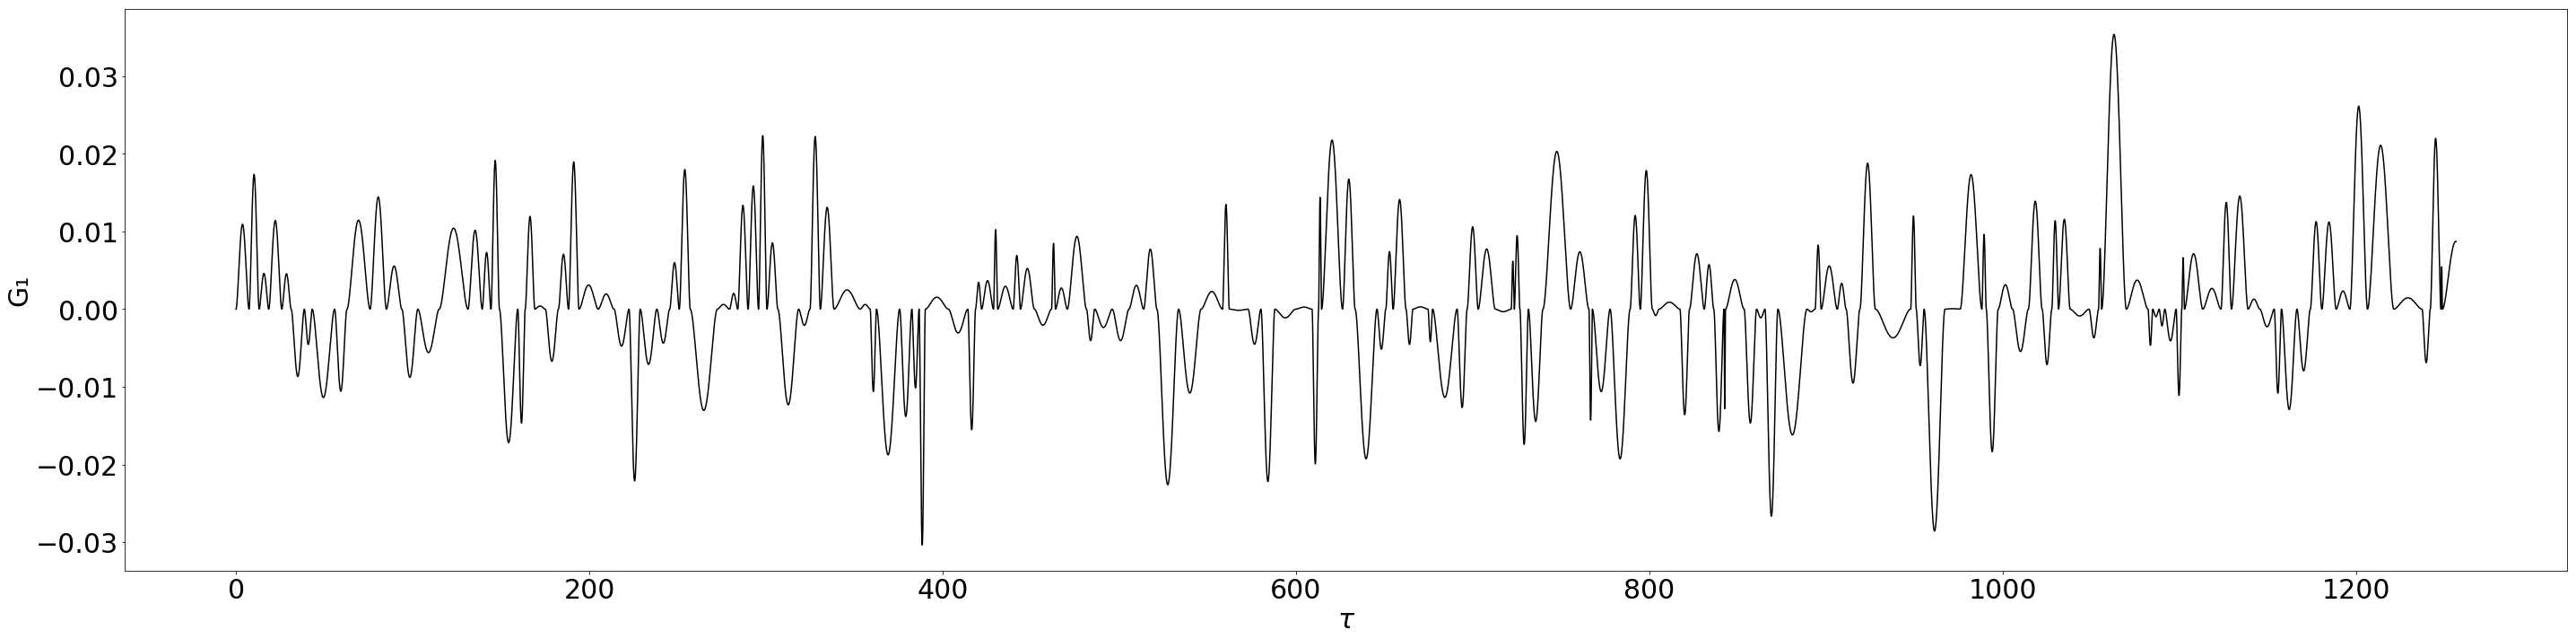

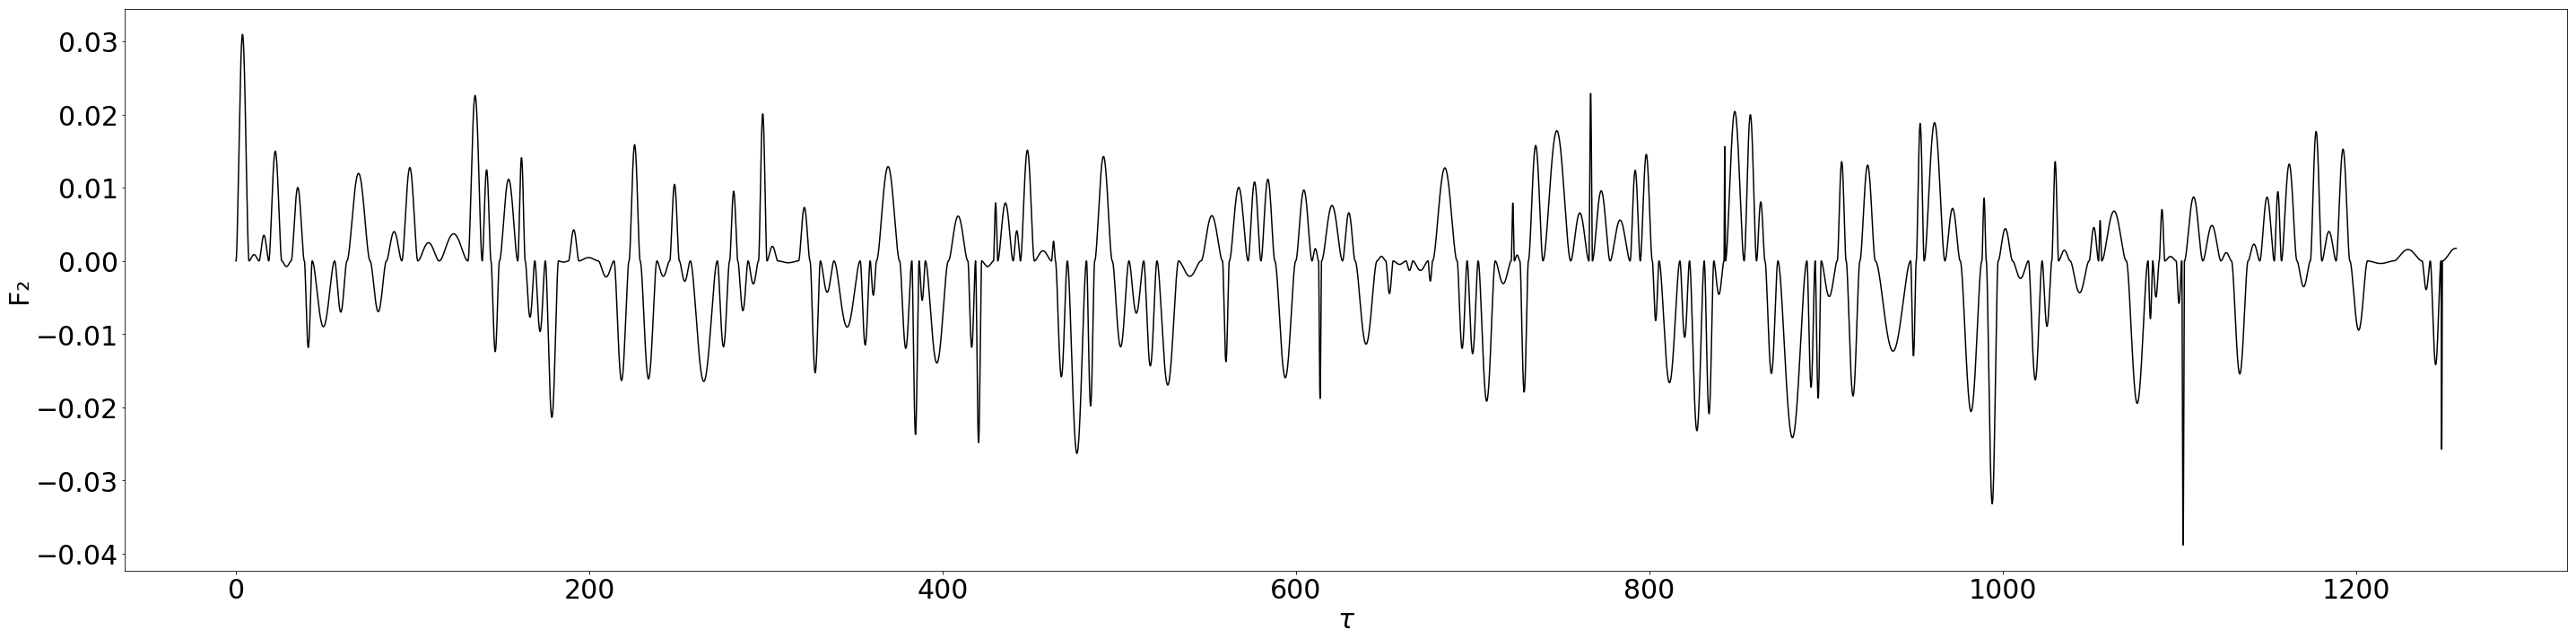

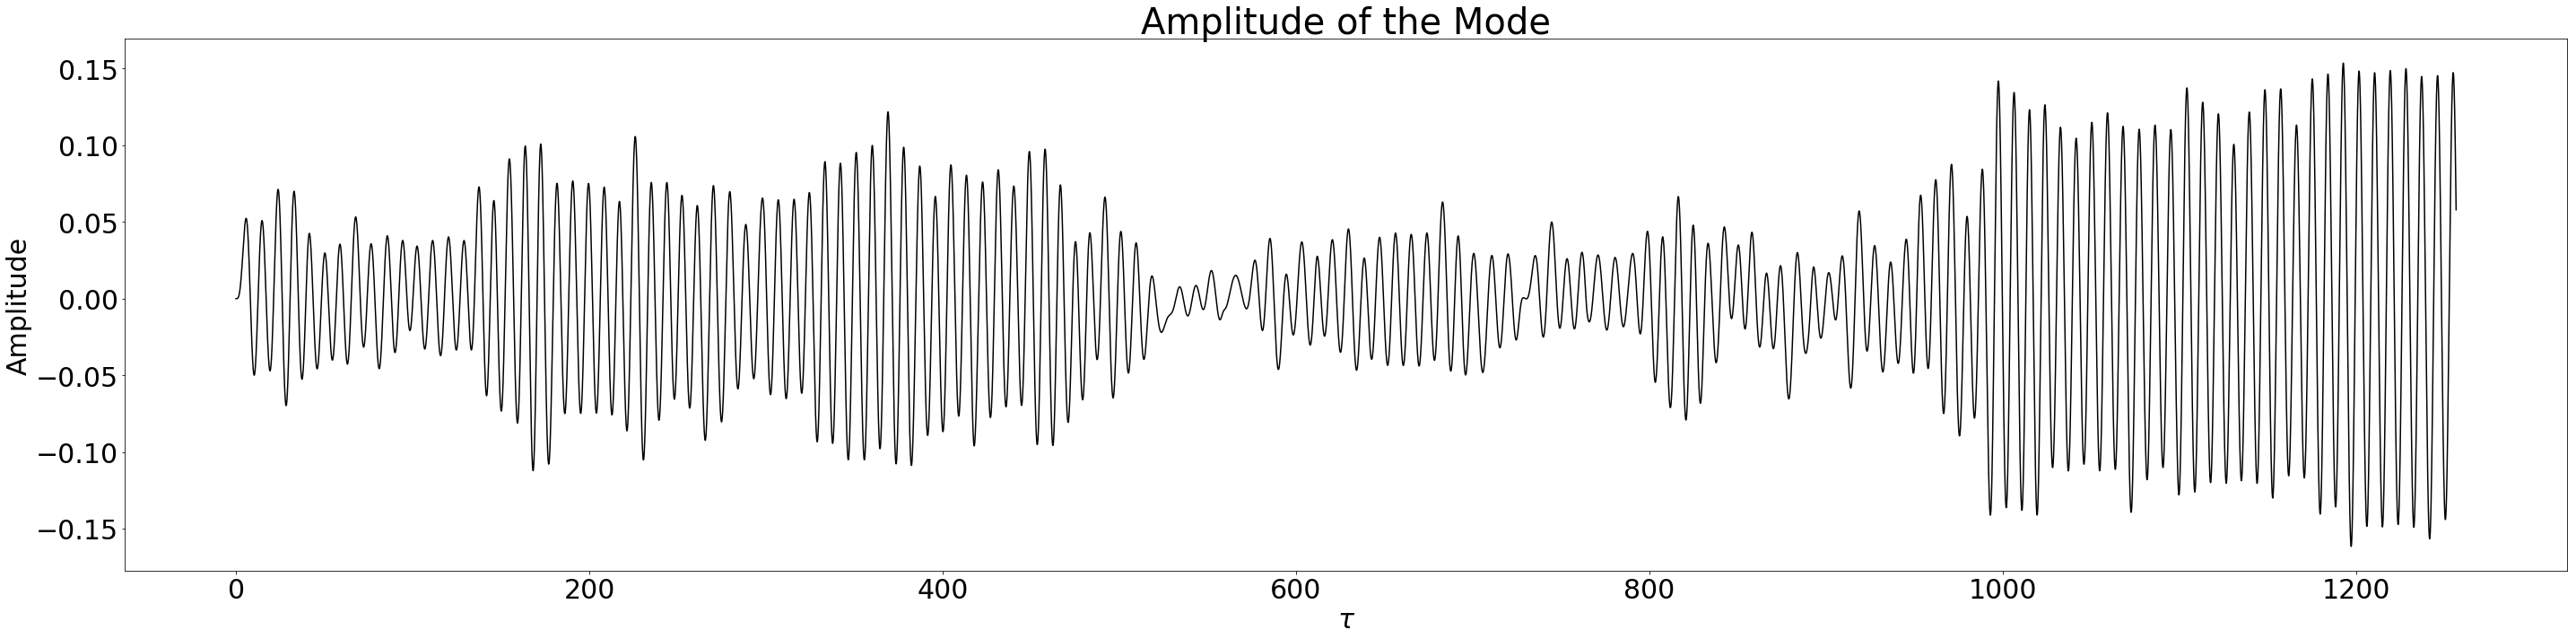

In [14]:
# plot the shorter plot
duration = 2 * np.pi * M_short
tshort = []
amptshort = []
f1short = []
f2short = []
g1short = []
ampshort= []

index =0
while time[index] < duration:
    tshort.append(time[index])
    f1short.append(F1[index])
    f2short.append(F2[index])
    g1short.append(G1[index])
    index += 1
    
index = 0
while amptime[index] < duration:
    amptshort.append(amptime[index])
    ampshort.append(Amp[index])
    index += 1

Funplots(tshort, g1short, f1short, f2short)
FunplotAmp(amptshort, ampshort)

## Amplification Distribution Function

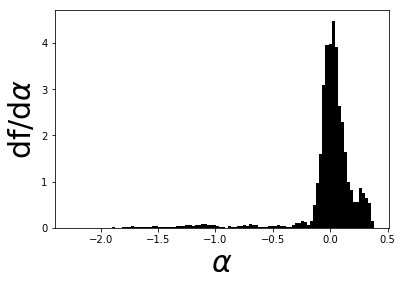

In [15]:
delt = N * meandeltaT

alpha = []
funAlpha(Amp, amptime, alpha, delt)

alpha = flatten(alpha)

# divide the full range alpha_min <= alpha <= alpha_max into m equal intervals
# we want m_max << number of samples = L * T(max)/delT = L * M / N
# m_max = L * M / N
m = 100
alpha_max = max(alpha)
alpha_min = min(alpha)

# dalpha = (alpha_max - alpha_min) / m ~ 4/m
# dalpha is the width of each bin
dalpha = (alpha_max - alpha_min) / m

# plot delf / delalpha vs. alpha
# where delf is the fraction of collected values of alpha within each bin of width delalpha

histogram = plt.hist(alpha, bins = m, range = [alpha_min, alpha_max], density=True, color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('df/d'r'$ \alpha $', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Cumulative Distribution Function

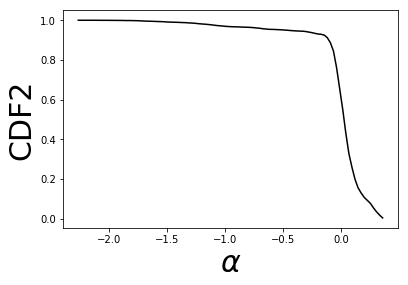

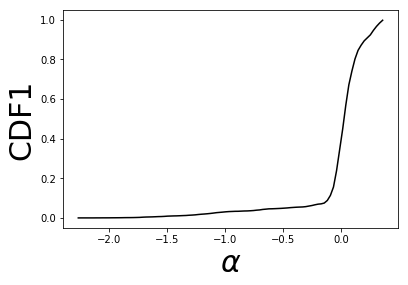

In [16]:
# CDF2 = int (df/dalpha) wrt dalpha from alpha to alpha_max
#      = 1 - CDF1
#      = 1 - int (df/dalpha) wrt dalpha from alpha_min to alpha

CDF1 = []
CDF2 = []

# dfdalpha values pulled from histogram above
dfdalpha = histogram[0]
alpha_values = histogram[1]
alpha_values = alpha_values[:-1]

index_max = len(dfdalpha)

for index in range(len(dfdalpha)):
    index_start = index
    total = 0
    for index_current in range(index_start, index_max):
        total += dfdalpha[index_current] * dalpha
    CDF1.append(1 - total)
    CDF2.append(total)

# plot CDF1 and CDF2
plt.plot(alpha_values, CDF2,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF2', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

plt.plot(alpha_values, CDF1,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF1', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Table 1 Values

In [17]:
total_F1 = flatten(total_F1)
F1rms = FunRMS(total_F1)
print("<F1^2>^(1/2) = ", F1rms)

total_G1 = flatten(total_G1)
G1rms = FunRMS(total_G1)
print("<G1^2>^(1/2) = ", G1rms)

total_F2 = flatten(total_F2)
F2rms = FunRMS(total_F2)
print("<F2^2>^(1/2) = ", F2rms)

total_Amp = flatten(total_Amp)
Arms = FunRMS(total_Amp)
print("<A^2> =", Arms ** 2 )

<F1^2>^(1/2) =  0.0012511869066253241
<G1^2>^(1/2) =  0.00792752769080246
<F2^2>^(1/2) =  0.007863500152381854
<A^2> = 1.3696100379306204


## Duty Cycle

In [18]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def duty_cycle(CDF2, k):
    # finds where CDF2 = 1/2
    CDF2_median = find_nearest(CDF2, 1/2)
    index_median =  np.where(CDF2 == CDF2_median)

    # finds alpha star
    alpha_star = alpha_values[index_median[0]]

    # finds CDF2(alpha_star + log(k))
    # alpha find is alpha_star+log(k)
    alpha_find = find_nearest(alpha_values, alpha_star + math.log(k, 10))
    index_find = np.where(alpha_values == alpha_find)
    
    psi = CDF2[int(index_find[0])]

    print("psi(", k, ") =", psi)

duty_cycle(CDF2, 5)

psi( 5 ) = 0.0036349269063611
